In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import tensorflow as tf
import pywt
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
from sklearn import metrics


C:\Users\nikit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nikit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nikit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nikit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
tf.contrib.eager.num_gpus()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



1

In [3]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = 'C:/Users/nikit/Downloads/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
#Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
#agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
#agg_df = agg_df[agg_df.diagnostic == 1]


# Apply diagnostic superclass


# Convert to dataframe
y_true = pd.DataFrame(data=Y)

# Dropping empty values
nan_value = float("NaN")
y_true.replace("", nan_value, inplace=True)


# Load raw signal data
X = load_raw_data(y_true, sampling_rate, path)

# Creating labels
#print(labels(y_true['diagnostic_superclass']))

#convert numpy array into tensor
def converter(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg


print(y_true['scp_codes'].astype('str').unique())
#print(y_true)
#type(Y['diagnostic_superclass'])
#print(Y['diagnostic_superclass'])

["{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}" "{'NORM': 80.0, 'SBRAD': 0.0}"
 "{'NORM': 100.0, 'SR': 0.0}" ...
 "{'IMI': 100.0, 'ISCLA': 50.0, 'ABQRS': 0.0, 'SVARR': 0.0}"
 "{'IMI': 80.0, 'ISCLA': 100.0, 'PVC': 100.0, 'ABQRS': 0.0, 'SR': 0.0}"
 "{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'STACH': 0.0}"]


In [4]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].sex
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].sex

In [5]:
def create_cwt_images(data, n_scales, rescale_size, wavelet_name="morl"):
    n_patients = data.shape[0]
    n_leads = data.shape[2]

    # range of scales from 1 to n_scales
    scales = np.arange(1, n_scales + 1)

    # pre allocate array
    data_cwt = np.ndarray(shape=(n_patients, rescale_size, rescale_size, n_leads), dtype='float32')

    sample = 0
    signal = 0

    for sample in range(n_patients):
        for signal in range(n_leads):
            #leads
            lead = data[sample, :, signal]
            # continuous wavelet transform
            coeffs, freqs = pywt.cwt(lead, scales, wavelet_name)
            # resize the 2D cwt coeffs
            rescale_coeffs = resize(coeffs, (rescale_size, rescale_size), mode='constant')
            data_cwt[sample, :, :, signal] = rescale_coeffs

    return data_cwt


# amount of pixels in X and Y
rescale_size = 32
# determine the max scale size
n_scales = 32

X_train_cwt = create_cwt_images(X_train, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: {X_train_cwt.shape}")
X_test_cwt = create_cwt_images(X_test, n_scales, rescale_size)
print(f"shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: {X_test_cwt.shape}")

shapes (n_samples, x_img, y_img, z_img) of X_train_cwt: (19634, 32, 32, 12)
shapes (n_samples, x_img, y_img, z_img) of X_test_cwt: (2203, 32, 32, 12)


In [6]:
def build_cnn_model(activation, input_shape):
    # Defining basic NN
    model = Sequential()

    # 2 Convolution layer with Max polling
    model.add(Conv2D(64, 5, activation=activation, padding='same', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, 5, activation=activation, padding='same', kernel_initializer="he_normal"))
    model.add(MaxPooling2D())
    model.add(Flatten())

    # 3 Full connected layer
    model.add(Dense(256, activation=activation, kernel_initializer="he_normal"))
    model.add(Dense(54, activation=activation, kernel_initializer="he_normal"))
    model.add(Dense(2, activation='softmax'))  # 2 classes

    # summarize the model
    print(model.summary())
    return model

In [7]:
def compile_and_fit_model(model, X_traina, y_traina, X_testa, y_testa, batch_size, n_epochs):
    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])

    # define callbacks
    callbacks = [
        ModelCheckpoint(filepath='best_model.h5', monitor='val_sparse_categorical_accuracy', save_best_only=True)]

    # fit the model
    history = model.fit(x=X_traina,
                        y=y_traina,
                        batch_size=batch_size,
                        epochs=n_epochs,
                        verbose=1,
                        callbacks=callbacks,
                        validation_data=(X_testa, y_testa))

    return model, history

In [8]:

# shape of the input images
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_test_cwt, y_test, 368, 20 )


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
____

In [ ]:
""""def create_confusion_matrix(y_preda, y_testa):
    # calculate the confusion matrix
    confmat = metrics.confusion_matrix(y_true=y_testa, y_pred=y_preda)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(confmat, cmap=plt.cm.Blues, alpha=0.5)

    n_labels = len(LABEL_NAMES)
    ax.set_xticks(np.arange(n_labels))
    ax.set_yticks(np.arange(n_labels))
    ax.set_xticklabels(LABEL_NAMES)
    ax.set_yticklabels(LABEL_NAMES)

    # rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # loop over data dimensions and create text annotations.
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center')

    # avoid that the first and last row cut in half
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    ax.set_title("Confusion Matrix")
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()"""

In [10]:
# make predictions for test data
y_pred = trained_cnn_model.predict_classes(X_test_cwt)
# determine the total accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.86%


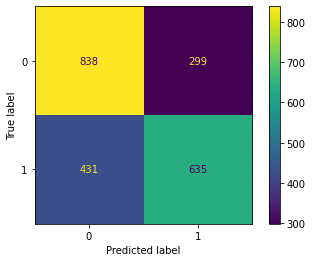

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = trained_cnn_model.predict_classes(X_test_cwt)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

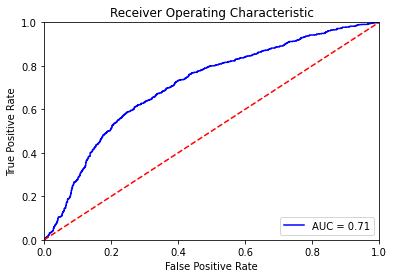

In [12]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = trained_cnn_model.predict_proba(X_test_cwt)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [13]:
# shape of the input images
input_shape = (X_train_cwt.shape[1], X_train_cwt.shape[2], X_train_cwt.shape[3])

# create cnn model
cnn_model = build_cnn_model("relu", input_shape)
# train cnn model
trained_cnn_model, cnn_history = compile_and_fit_model(cnn_model, X_train_cwt, y_train, X_test_cwt, y_test, 368, 50 )


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        19264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 54)               

In [17]:
# make predictions for test data
y_pred = trained_cnn_model.predict_classes(X_test_cwt)
# determine the total accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 66.41%


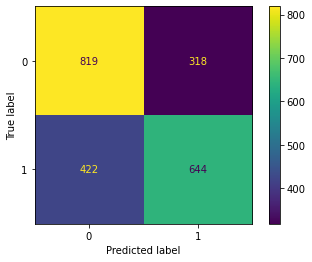

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = trained_cnn_model.predict_classes(X_test_cwt)
cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

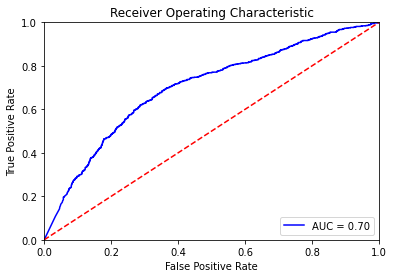

In [19]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = trained_cnn_model.predict_proba(X_test_cwt)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
